In [1]:
%load_ext autoreload

In [168]:
%autoreload
import copy
import sys
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from einops import rearrange
from functorch import vmap
from torch.utils.data import DataLoader, random_split
from tqdm.auto import tqdm

sys.path.append("/scratch/gpfs/js5013/programs/cfilt/")
from cfilt.utils import *

In [7]:
def remove_data_parallel(old_state_dict):
    new_state_dict = OrderedDict()

    for k, v in old_state_dict.items():
        name = k[7:]  # remove `module.`
        new_state_dict[name] = v

    return new_state_dict

In [238]:
ds = CDS(
    [1, 4, 8, 16, 32, 80, 160, 320, 1600],
    "jx",
    "../out/",
    crop=True,
    normalize=True,
    transform=transforms.ToTensor(),
)

  0%|          | 0/9 [00:00<?, ?it/s]

In [199]:
train_len = int(len(ds) * 0.95)
train_ds, test_ds = random_split(ds, (train_len, len(ds) - train_len))

dl_cfg = dict(
    batch_size=4,
    shuffle=True,
    collate_fn=unpack,
    num_workers=16,
    pin_memory=True,
)
train_dl = DataLoader(train_ds, **dl_cfg)
test_dl = DataLoader(test_ds, **dl_cfg)

In [200]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [214]:
# ac = nn.Conv2d(1, 1, (3, 3), padding=1, bias=False).to(device) # 1 layer
ac = nn.Sequential(
    ConvXCoder((121, 128), 1, 8, 8, 3, device),
    ConvXCoder((121, 128), 8, 1, 8, 3, device),
)

In [215]:
optimizer = torch.optim.Adam(ac.parameters(), lr=1e-2)
loss_fn = MS_SSIM_L1_Loss(alpha=0.7)
maploss = vmap(loss_fn, in_dims=0)

In [216]:
mapfft = vmap(torch.fft.fft2, in_dims=0)

In [257]:
epochs = 100
# losses = []
for e in (pbar := tqdm(range(epochs))):
    ac.train()
    for i, x in enumerate(train_dl):
        optimizer.zero_grad()

        out = ac(x[0].to(device))
        loss_base = loss_fn(out, x[-1].to(device))
        out_fft = mapfft(out[:, 0])
        loss_fft = torch.linalg.norm(out_fft - mapfft(x[-1][:, 0].to(device)))
        loss = loss_base * 1 + loss_fft * 0.02

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    pbar.set_description(f"loss: {loss.item():.2e}")

  0%|          | 0/100 [00:00<?, ?it/s]

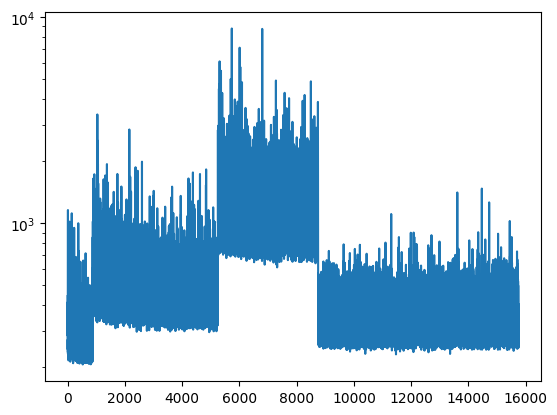

In [258]:
plt.plot(losses)
plt.yscale("log")

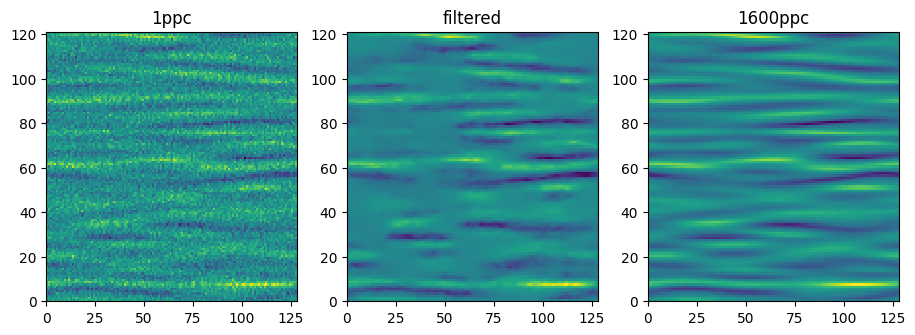

In [259]:
ac.eval()
im4 = ds.images[4][8]
im4o = ac(torch.tensor(im4).to(device)).detach().cpu().numpy()[0][0]
fig, ax = qplot([im4, im4o, ds.images[1600][8]], lambda x: x)
titles = ["1ppc", "filtered", "1600ppc"]
for i in range(3):
    ax[i].set_title(titles[i])